In [7]:
import torch
from torch.autograd import Variable
from torchvision import models
import cv2
import sys
import numpy as np

from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

In [8]:
def draw_line(mask, color=(1,0,0), width=3):
    mapimg = (mask == 0).astype(int)

    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])


    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))

    # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))


    segments = np.array(l)

    x0=0
    x1=445
    y0=0
    y1=470

    segments[:,0] = x0 + (x1-x0) * segments[:,0] / mapimg.shape[1]
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / mapimg.shape[0]
    
    plt.plot(segments[:,0], segments[:,1], color=color, linewidth=width)

In [9]:
import torch
from torch.autograd import Variable
from torchvision import models
import cv2
import sys
import numpy as np

from matplotlib import pyplot as plt
#%matplotlib inline

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1 , :] - img[1 :, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[: , :-1] - img[: , 1 :])).pow(tv_beta))
    return row_grad + col_grad

def preprocess_image(img):    
    preprocessed_img = img.transpose(2,0,1).reshape(1,3,470,445)
    preprocessed_img_tensor = torch.from_numpy(preprocessed_img).type(torch.FloatTensor)

    #preprocessed_img_tensor.unsqueeze_(0)
    return Variable(preprocessed_img_tensor, requires_grad = False)

def sv_res(path, content, area_mask = None, do_mask = False):
    plt.ioff()
    fig = plt.figure()
    plt.imshow(np.uint8(255*content))
    if do_mask: 
        draw_line(area_mask, width=4, color=(0,0,0.7))
    fig.savefig(path, bbox_inches='tight')
    
def save(name, mask, img, area_mask = None, do_mask = False, full_mask = False):
    mask = mask.cpu().data.numpy()[0]
    mask_out = mask * (1-area_mask)
    
    mask = np.transpose(mask, (1, 2, 0))
    mask = (mask - np.min(mask)) / np.max(mask)
    mask = 1 - mask
    
    mask_out = np.transpose(mask_out, (1, 2, 0))
    mask_out = (mask_out - np.min(mask_out)) / np.max(mask_out)
    mask_out = 1 - mask_out
    
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap_out = cv2.applyColorMap(np.uint8(255*mask_out), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    heatmap_out = np.float32(heatmap_out) / 255
    
    cam = 1.0*heatmap + np.float32(img)/255
    cam = cam / np.max(cam)
    
    cam_out = 1.0*heatmap_out + np.float32(img)/255
    cam_out = cam_out / np.max(cam_out)
    
    pre_name = './gridsal-results/' + name + '/' + name
    if do_mask:
        pre_name = pre_name + '-mask'
    if full_mask:
        pre_name = pre_name + '-full'
        
    sv_res(pre_name + "-heatmap.png", heatmap, area_mask, do_mask)
    cv2.imwrite(pre_name + "-mask.png", np.uint8(255*mask))
    sv_res(pre_name + "-cam.png", cam, area_mask, do_mask)
    sv_res(pre_name + "-cam-out.png", cam_out, area_mask, do_mask)

def numpy_to_torch(img, requires_grad = True):
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        output = np.transpose(img, (2, 0, 1))

    output = torch.from_numpy(output)
    if use_cuda:
        output = output.cuda()

    output.unsqueeze_(0)
    v = Variable(output, requires_grad = requires_grad)
    return v

def load_model():
    model = torch.load('./result2/weights.pt')
    model.eval()
    return model

In [10]:
def explain_classification(name, do_mask = False):
    learning_rate = 0.1
    max_iterations = 200
    l1_coeff = 0.01
    image_path = "./carotida-binary/Images/" + name + ".jpg"

    model = load_model()
    original_img = cv2.imread(image_path, 1)
    img = np.float32(original_img) / 255

    blurred_img_init = np.float32(cv2.medianBlur(original_img, 21))/255

    # Convert to torch variables
    img = preprocess_image(img)
    blurred_img = preprocess_image(blurred_img_init)


    mask_init = np.ones((28, 28), dtype = np.float32)
    mask = numpy_to_torch(mask_init)

    upsample = torch.nn.UpsamplingBilinear2d(size=(470, 445)).cuda()

    optimizer = torch.optim.Adam([mask], lr=learning_rate)

    # Auxiliar zeros tensor
    zero_t = np.zeros((470, 445), dtype = np.float32)
    zero_t = numpy_to_torch(zero_t, requires_grad = False)

    # Initial segmentation
    target = model(img)['out']


    area_mask = (target.squeeze().cpu().data.numpy() > 0.5).astype(int)
    R = numpy_to_torch(area_mask, requires_grad = False)

    fcx = target.squeeze()
    l1r = torch.mean(torch.abs(1 - R))
    
    print("-------------------")
    print("IMAGE:" + name)
    print("-------------------")

    print("Optimizing.. ")
    print("Iterations:")
    
    for i in range(max_iterations):
        if i%25 == 0: 
            print(i)

        def_mask = upsample(mask)
        upsampled_mask = def_mask
        upsampled_mask = upsampled_mask.expand(1, 3, upsampled_mask.size(2),  upsampled_mask.size(3))

        # Use the mask to perturbated the input image.
        perturbated_input = img.mul(upsampled_mask) + blurred_img.mul(1-upsampled_mask)


        fcxp = model(perturbated_input)['out'].squeeze()
        subs = fcx - fcxp
        maxs = torch.max(subs,zero_t)
        mul = torch.mul(R, maxs)
        l1mul = torch.mean(torch.abs(mul))

        l1m = l1_coeff*torch.mean(torch.abs(mask))

        loss = l1m + (l1mul / l1r)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        mask.data.clamp_(0, 1)

    upsampled_mask = upsample(def_mask)
    save(name, upsampled_mask, original_img, area_mask, True, False)

    print("--------------END--------------")

In [11]:
path = "carotida-binary/Images"
images = [f for f in listdir(path) if isfile(join(path, f))]

FRACTION = 0.1

In [12]:
test_images = images[int(np.ceil(len(images)*(1-FRACTION))):]

In [15]:
import os
for image in test_images[9:]:
    name = image.replace(".jpg", "")
    #os.mkdir('gridsal-results/' + name )
    explain_classification(name, do_mask = False)

/home/ub/.local/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torchvision.models._utils.IntermediateLayerGetter' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ub/.local/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ub/.local/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torchvision.models.resnet.Bottleneck' has changed. you can retrieve the original source code by accessi

-------------------
IMAGE:33FP
-------------------
Optimizing.. 
Iterations:
0
25
50
75
100
125
150
175
--------------END--------------
-------------------
IMAGE:20TN
-------------------
Optimizing.. 
Iterations:
0
25
50
75
100
125
150
175
--------------END--------------
-------------------
IMAGE:16TP
-------------------
Optimizing.. 
Iterations:
0
25
50
75
100
125
150
175
--------------END--------------
-------------------
IMAGE:9FP
-------------------
Optimizing.. 
Iterations:
0
25
50
75
100
125
150
175
--------------END--------------
-------------------
IMAGE:1TN
-------------------
Optimizing.. 
Iterations:
0
25
50
75
100
125
150
175
--------------END--------------
-------------------
IMAGE:20FN
-------------------
Optimizing.. 
Iterations:
0
25
50
75
100
125
150
175
--------------END--------------


/home/ub/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


# See the images together

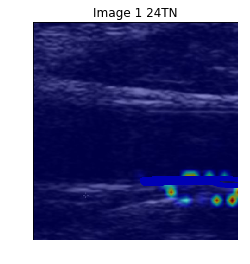

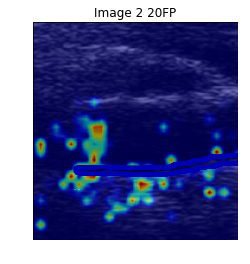

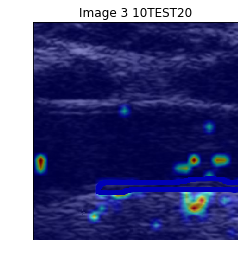

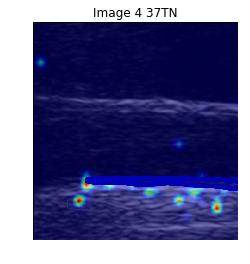

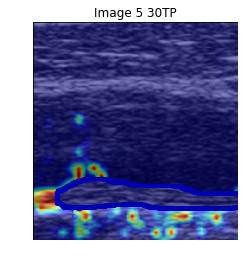

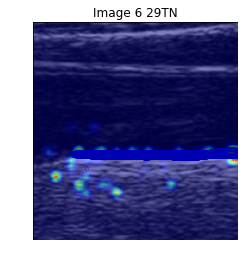

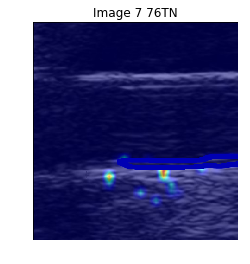

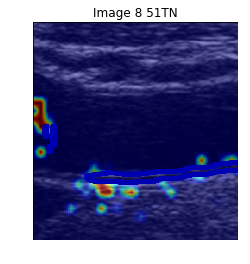

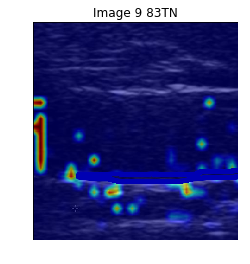

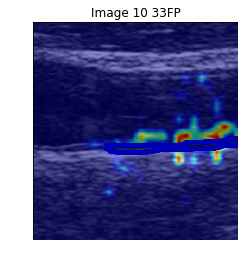

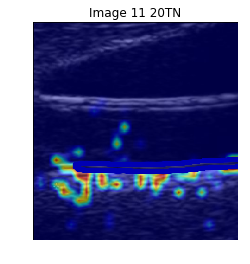

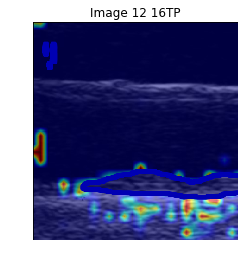

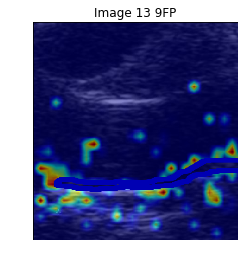

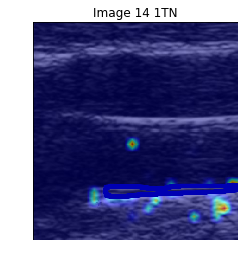

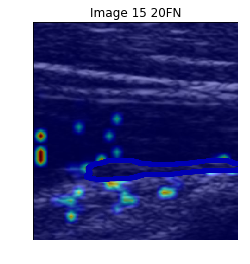

In [13]:

for i, image in enumerate(test_images):
    
    name = image.replace(".jpg", "") 
    gridsal = cv2.imread('./gridsal-results/' + name + '/' + name +'-mask-cam-out.png') 
    gridsal = cv2.cvtColor(gridsal, cv2.COLOR_BGR2RGB)
    gridsal = gridsal[10:227, 33:237]
    plt.title('Image ' + str(i+1)+ " " + name)
    plt.imshow(gridsal)
    plt.axis('off')
    plt.show()
